In [1]:
!nvidia-smi

Sun May  7 15:49:42 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 6000                 On | 00000000:1B:00.0 Off |                  Off |
| 33%   25C    P8                9W / 260W|    751MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf 
from xgboost import XGBClassifier

from dask.distributed import Client
from dask_cuda import LocalCUDACluster
from dask_ml.model_selection import GridSearchCV
import dask.dataframe as dd

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from Loader import train_data_vgg16

2023-05-07 15:49:43.778510: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
####################################################################
# Following code releases unused GPU memory for others to use.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
####################################################################

2023-05-07 15:49:46.584039: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-07 15:49:46.584152: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-07 15:49:46.610980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-07 15:49:46.611518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1c:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-07 15:49:46.612000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 2 with properties: 
pciBusID: 0000:1d:00.0 name: Quadro RTX 600

In [4]:
df = train_data_vgg16()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,class
0,27.489744,0.0,0.000000,0.000000,0.000000,4.406033,0.000000,0.000000,0.0,9.508491,...,0.000000,0.0,0.0,0.0,3.239264,5.528229,0.0,0.0,0.00000,Real
1,0.000000,0.0,0.000000,27.298634,0.000000,21.718521,17.454420,0.000000,0.0,14.870244,...,0.000000,0.0,0.0,0.0,0.000000,22.730530,0.0,0.0,0.00000,Real
2,0.000000,0.0,0.000000,0.000000,0.000000,7.493243,0.000000,1.344108,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000,Real
3,0.000000,0.0,29.934219,39.067970,0.000000,24.231049,6.911931,0.000000,0.0,0.000000,...,16.403683,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,17.57489,Real
4,0.000000,0.0,0.000000,24.634619,26.340034,0.000000,0.000000,0.000000,0.0,0.000000,...,13.876423,0.0,0.0,0.0,0.000000,28.267170,0.0,0.0,0.00000,Real


In [5]:
df_sample = df.sample(frac=1.0, random_state=0)

In [6]:
X = df_sample.drop('class', axis=1)

le = LabelEncoder()
y = df_sample['class']
y = pd.DataFrame(le.fit_transform(y), columns=['class'])  # encode y to be numeric

X.head()

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
3582,0.000000,0.0,0.0,0.000000,4.260871,18.161793,0.0,0.000000,0.0,20.675310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
10498,32.219925,0.0,0.0,24.435274,0.000000,0.000000,0.0,2.313794,0.0,10.794803,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
3227,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,65.122879
21333,22.872917,0.0,0.0,0.000000,30.738342,34.451023,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
3885,28.040337,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,65.730591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50366,0.000000


In [7]:
X_dask = dd.from_pandas(X, npartitions=1)
y_dask = dd.from_pandas(y, npartitions=1)

In [8]:
cluster = LocalCUDACluster(n_workers=8)
client = Client(cluster)

with cluster:
    with Client(cluster) as client:
        grid = {
            'max_depth': [1, 2, 3, 4, 5],
            'learning_rate': [0.5, 0.1, 0.05, 0.01, .005, 0.001],
            'n_estimators': np.arange(10000, 110000, 10000)
        }

        time_start = time()

        gbt = XGBClassifier(tree_method='gpu_hist')
        gbtCV = GridSearchCV(gbt, param_grid=grid, return_train_score=True, n_jobs = -1)
        gbtCV.fit(X_dask, y_dask)

        time_stop = time()
        print('Elapsed Time for GBT:', (time_stop - time_start) / 60)

client.close()
cluster.close()

/home/bowerirn/.local/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44273 instead
  warnings.warn(
2023-05-07 15:49:54,647 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-07 15:49:54,647 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-07 15:49:54,650 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-07 15:49:54,650 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-07 15:49:54,693 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-07 15:49:54,693 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-05-07 15:49:54,751 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-05-07 15:49:54,751 - distributed.preloading - INFO - Import preload module: d

Elapsed Time for GBT: 701.5172586679458


In [9]:
gbtCV.best_score_

0.50351

In [10]:
gbtCV.best_params_

{'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 20000}

<AxesSubplot: xlabel='param_max_depth-param_learning_rate', ylabel='param_n_estimators'>

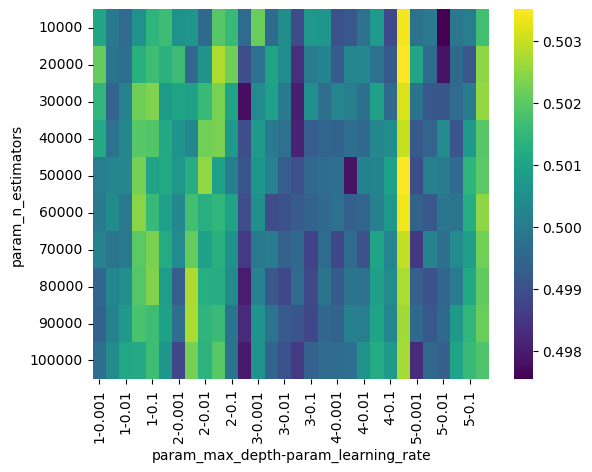

In [11]:
import seaborn as sns

cv_results = gbtCV.cv_results_
df_results = pd.DataFrame(cv_results)
df_results = df_results[['param_max_depth', 'param_learning_rate', 'param_n_estimators', 'mean_test_score']]
df_results = df_results.pivot_table(index='param_n_estimators', columns=['param_max_depth', 'param_learning_rate'], values='mean_test_score')
sns.heatmap(df_results, cmap='viridis')